In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
TRAIN_PATH = "../data/train.pickle"
LABEL_PATH = "../data/label_names.csv"

## Easy

Скачаем сам датасет и названия всех знаков

In [3]:
data = pd.read_pickle(TRAIN_PATH)
label_arr = pd.read_csv(LABEL_PATH)

In [4]:
data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [5]:
unique, count_label = np.unique(data['labels'], return_counts=True)
df_count_label = pd.DataFrame({'label': label_arr.SignName, 'count': count_label})

<Axes: ylabel='count'>

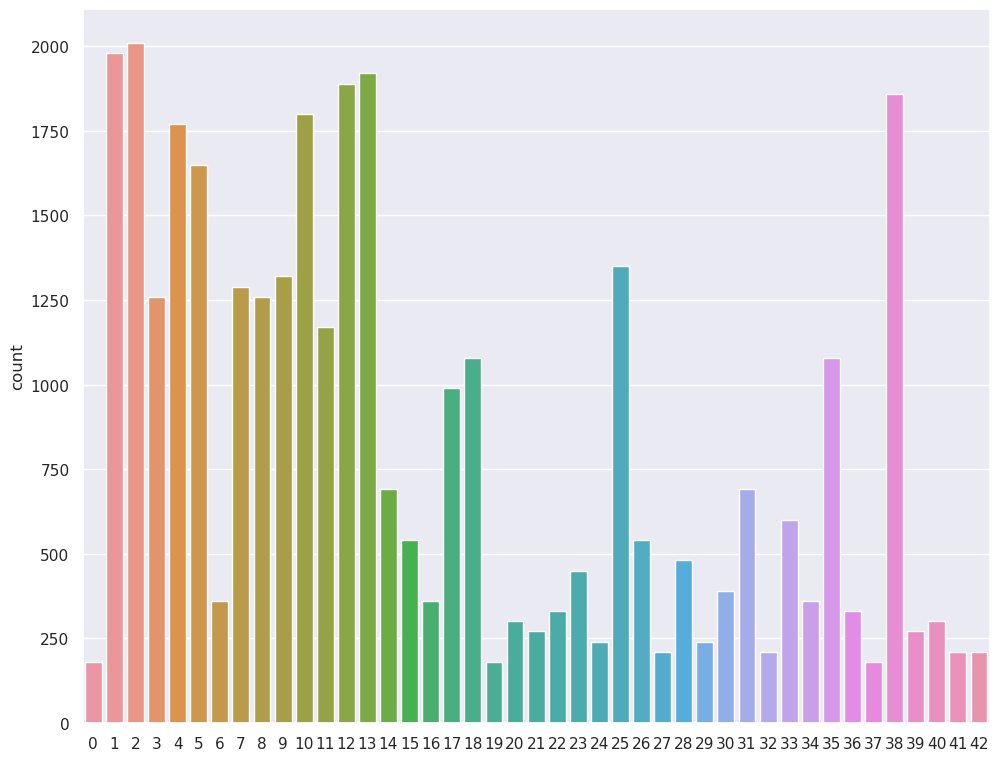

In [6]:
sns.set_theme(rc={'figure.figsize':(11.7,9.27)})
sns.countplot(x=data['labels'], data=pd.DataFrame(data['labels']))

In [7]:
df_count_label[df_count_label['count'] <= 250]

,label,count
0,Speed limit (20km/h),180
19,Dangerous curve to the left,180
24,Road narrows on the right,240
27,Pedestrians,210
29,Bicycles crossing,240
32,End of all speed and passing limits,210
37,Go straight or left,180
41,End of no passing,210
42,End of no passing by vehicles over 3.5 metric ...,210


По графику видно, что данные не распределены равномерно, например, "Speed limit (20km/h)", "Dangerous curve to the left", "Road narrows on the right", "Pedestrians", "Bicycles crossing" и других знаков значительно меньше остальных     

In [8]:
x = list()
y = list()
for i in range(len(data['features'])):
    x.append(data['features'][i].ravel())
    y.append(data['labels'][i])
x = np.array(x)
y = np.array(y)

x = x / 255

In [9]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.33, shuffle=True)

Обучим логистическую регрессию. Сразу посмотрим сразу на accuracy(как часто делается верное предсказание), precision(способность отличать класс от других) и recall(способность распознавать класс). Нужно считать сразу метрики для каждого класса, чтобы выявить, что какой-то класс может угадываться хуже всех

In [10]:
model = LogisticRegression(max_iter=1500)

model.fit(x_train, y_train)
        
y_pred = model.predict(x_test)

log_reg_acc = accuracy_score(y_test, y_pred)
log_reg_precision = precision_score(y_test, y_pred, average=None)
log_reg_recall = recall_score(y_test, y_pred, average=None)

print(f"LogReg accuracy: {log_reg_acc}")
print(f"LogReg precision: {log_reg_precision}")
print(f"LogReg minimal precision: {min(log_reg_precision)}")
print(f"LogReg recall: {log_reg_recall}")
print(f"LogReg minimal recall: {min(log_reg_recall)}")

LogReg accuracy: 0.9541100661790317
LogReg precision: [0.87692308 0.94871795 0.93390805 0.91626794 0.92416226 0.8479021
 0.92173913 0.96368039 0.91704036 0.99026764 0.9600639  0.96666667
 0.99341021 0.9823435  0.99009901 0.91525424 0.97435897 0.98083067
 0.95026178 0.98148148 0.91346154 0.9673913  0.9453125  0.95890411
 0.94871795 0.96983759 0.94642857 0.98333333 0.95783133 0.91025641
 0.96240602 0.93775934 0.92105263 1.         0.97457627 0.99438202
 0.97849462 0.95238095 0.99029126 1.         0.9893617  0.95945946
 1.        ]
LogReg minimal precision: 0.8479020979020979
LogReg recall: [0.890625   0.925      0.93123209 0.87844037 0.95620438 0.94911937
 0.96363636 0.92773893 0.95784543 0.92710706 0.98042414 0.96666667
 0.98852459 0.96075353 0.98039216 0.94736842 0.97435897 0.99032258
 0.98373984 0.86885246 0.94059406 0.94680851 0.99180328 0.93333333
 0.87058824 0.96983759 0.9244186  0.86764706 0.94642857 0.83529412
 0.94117647 0.9338843  0.97222222 0.99473684 0.98290598 0.98333333
 0.

Видно, что accuracy несильно отличается от большей части precision и recall, значит, модель довольно точно определяет классы

Посмотрим на то, как модель угадала каждый из знаков, будем использовать метрику F-меру, т.к. это среднее гармоническое recall и precision

In [11]:
most_unrecognizable = None
most_unrecognizable_score = 1
less_than_09 = []
for i in range(len(label_arr)):
    score = f1_score(y_test, y_pred, labels=[i], average=None)
    print(f"{label_arr.iloc[i]['SignName']}: {score}")
    if score < 0.9:
        less_than_09.append((score, label_arr.iloc[i]['SignName']))
    if score < most_unrecognizable_score:
        most_unrecognizable_score = score
        most_unrecognizable = label_arr.iloc[i]['SignName']

Speed limit (20km/h): [0.88372093]
Speed limit (30km/h): [0.93670886]
Speed limit (50km/h): [0.93256815]
Speed limit (60km/h): [0.8969555]
Speed limit (70km/h): [0.93991031]
Speed limit (80km/h): [0.8956602]
End of speed limit (80km/h): [0.94222222]
Speed limit (100km/h): [0.94536817]
Speed limit (120km/h): [0.93699885]
No passing: [0.95764706]
No passing for vehicles over 3.5 metric tons: [0.97013721]
Right-of-way at the next intersection: [0.96666667]
Priority road: [0.99096138]
Yield: [0.97142857]
Stop: [0.98522167]
No vehicles: [0.93103448]
Vehicles over 3.5 metric tons prohibited: [0.97435897]
No entry: [0.98555377]
General caution: [0.96671105]
Dangerous curve to the left: [0.92173913]
Dangerous curve to the right: [0.92682927]
Double curve: [0.95698925]
Bumpy road: [0.968]
Slippery road: [0.94594595]
Road narrows on the right: [0.90797546]
Road work: [0.96983759]
Traffic signals: [0.93529412]
Pedestrians: [0.921875]
Children crossing: [0.95209581]
Bicycles crossing: [0.87116564]

In [12]:
less_than_09

[(array([0.88372093]), 'Speed limit (20km/h)'),
 (array([0.8969555]), 'Speed limit (60km/h)'),
 (array([0.8956602]), 'Speed limit (80km/h)'),
 (array([0.87116564]), 'Bicycles crossing')]

In [13]:
print(f"Most Unrecognizable - {most_unrecognizable}: {most_unrecognizable_score}")

Most Unrecognizable - Bicycles crossing: [0.87116564]


Хуже всего угадывает "Bicycles crossing", а также "Speed limit (20km/h)"/(60km/h)/(80km/h)  

## Medium

In [14]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

import seaborn as sns

In [15]:
svc_acc = []
svc_precision = []
svc_recall = []

for kernel in ['linear', 'poly', 'rbf']:
    model_svc = SVC(kernel=kernel, max_iter=400, degree=2)
    
    model_svc.fit(x_train, y_train)
    
    y_pred = model_svc.predict(x_test)
    
    ker_svc_acc = accuracy_score(y_test, y_pred)
    ker_svc_precision = precision_score(y_test, y_pred, average=None)
    ker_svc_recall = recall_score(y_test, y_pred, average=None)
    
    svc_acc.append(ker_svc_acc)
    svc_precision.append(ker_svc_precision)
    svc_recall.append(ker_svc_recall)
    
    print(f'{kernel} accuracy: {ker_svc_acc}')
    print(f'{kernel} precicision: {ker_svc_precision}')
    print(f'{kernel} minimal precicision: {min(ker_svc_precision)}')
    print(f'{kernel} recall: {ker_svc_recall}')
    print(f'{kernel} minimal recall: {min(ker_svc_recall)}')

linear accuracy: 0.9008185301288749
linear precicision: [0.71084337 0.81350954 0.76880985 0.66483516 0.92235294 0.670194
 0.95614035 0.90862944 0.71111111 0.97368421 0.9933222  0.89498807
 0.9966443  0.9903537  0.97087379 0.88571429 0.91269841 0.99339934
 0.95977011 0.96491228 0.96938776 0.88461538 0.96031746 0.8875
 0.87777778 0.98809524 0.93413174 0.96721311 0.94512195 0.85106383
 0.93233083 0.97046414 0.8045977  1.         0.98290598 0.95698925
 0.93684211 1.         0.98858075 1.         0.98947368 0.97297297
 0.98507463]
linear minimal precicision: 0.6648351648351648
linear recall: [0.921875   0.865625   0.80515759 0.55504587 0.71532847 0.74363992
 0.99090909 0.83449883 0.89929742 0.92710706 0.97063622 0.96153846
 0.97377049 0.96703297 0.98039216 0.90643275 0.98290598 0.97096774
 0.90514905 0.90163934 0.94059406 0.9787234  0.99180328 0.94666667
 0.92941176 0.96287703 0.90697674 0.86764706 0.92261905 0.94117647
 0.91176471 0.95041322 0.97222222 1.         0.98290598 0.98888889
 0.9

Хуже всех работает полиномиальное ядро, т.к. оно очень чувствительно к переобучению, особенно при больших степенях. Аналогично для rbf, оно так же могло переобучиться

Выберем гиперпараметр для KNN

In [16]:
neib = []
k_n = 0
max_score = 0
for k in range(3, 12):
    model = KNeighborsClassifier(n_neighbors=k)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    neib.append((score, k))
    if max_score < score:
        max_score = score
        k_n = k
print(f"knn core: {max_score}")

knn core: 0.885841170323929


In [17]:
print(k_n)

3


<Axes: xlabel='k', ylabel='score'>

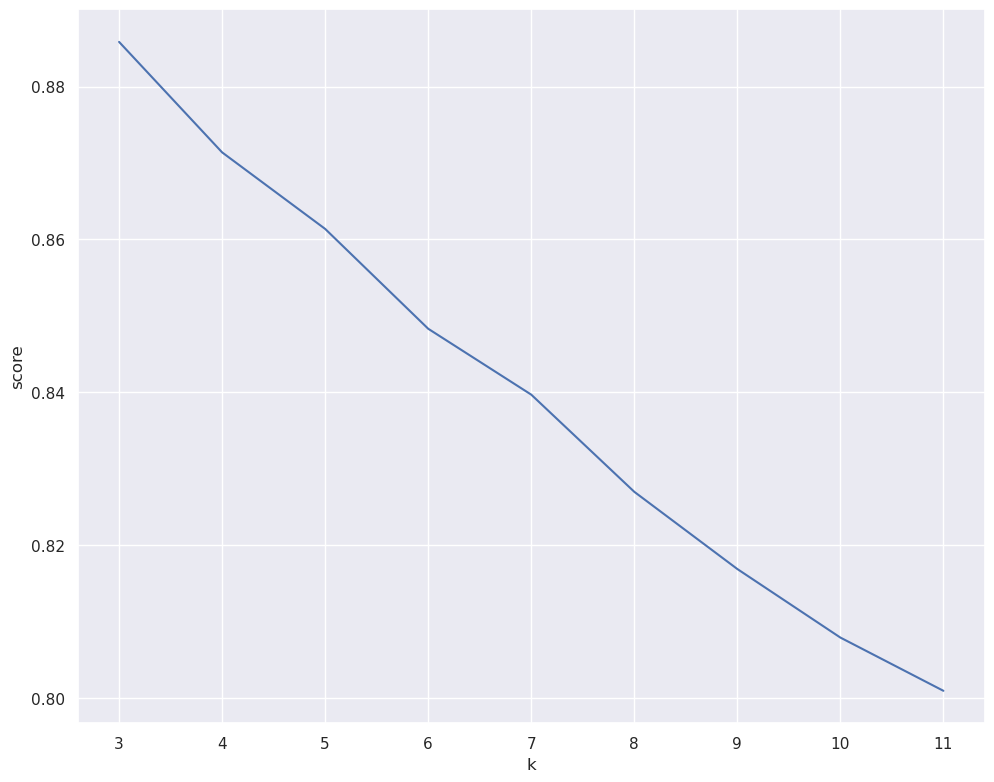

In [18]:
df = pd.DataFrame(np.array(neib), columns=['score', 'k'])
sns.lineplot(df, x='k', y='score')

In [19]:
model = KNeighborsClassifier(n_neighbors=k_n)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

knn_acc = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred, average=None)
knn_recall = recall_score(y_test, y_pred, average=None)

print(f"KNN accuracy: {knn_acc}")
print(f"KNN precision: {knn_precision}")
print(f"KNN minimal precision: {min(knn_precision)}")
print(f"KNN recall: {knn_recall}")
print(f"KNN minimal recall: {min(knn_recall)}")

KNN accuracy: 0.885841170323929
KNN precision: [0.77941176 0.84062059 0.85569986 0.75806452 0.79966044 0.67950693
 0.90909091 0.78181818 0.85681818 0.93285372 0.91530945 0.91008174
 0.97491039 0.96025437 0.98369565 0.9261745  0.95833333 0.97658863
 0.88051948 0.96153846 0.87878788 0.95348837 0.95041322 0.97183099
 0.92207792 0.95090439 0.91017964 0.92982456 0.96774194 0.97142857
 0.86713287 0.81021898 0.85714286 0.97727273 0.9380531  0.95238095
 0.95238095 0.96296296 0.92857143 0.98924731 0.90526316 0.98412698
 1.        ]
KNN minimal precision: 0.6795069337442219
KNN recall: [0.828125   0.93125    0.8495702  0.75458716 0.85948905 0.8630137
 0.90909091 0.9020979  0.88290398 0.88610478 0.91680261 0.85641026
 0.89180328 0.94819466 0.8872549  0.80701754 0.98290598 0.94193548
 0.91869919 0.81967213 0.86138614 0.87234043 0.94262295 0.92
 0.83529412 0.85382831 0.88372093 0.77941176 0.89285714 0.8
 0.91176471 0.91735537 0.91666667 0.90526316 0.90598291 0.88888889
 0.84210526 0.86666667 0.8834

KNN даёт довольно неплохую точность, несмотря на большое количество фич, однако всё ещё хуже логической регрессии

In [20]:
model = MultinomialNB()

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

nbc_acc = accuracy_score(y_test, y_pred)
nbc_precision = precision_score(y_test, y_pred, average=None)
nbc_recall = recall_score(y_test, y_pred, average=None)

print(f"MultinomialNB accuracy: {nbc_acc}")
print(f"MultinomialNB precision: {nbc_precision}")
print(f"MultinomialNB minimal precision: {min(nbc_precision)}")
print(f"MultinomialNB recall: {nbc_recall}")
print(f"MultinomialNB minimal recall: {min(nbc_recall)}")

MultinomialNB accuracy: 0.3331591779867642
MultinomialNB precision: [0.09025271 0.375      0.25624179 0.0984456  0.16569767 0.12318841
 0.5505618  0.28235294 0.04166667 0.55       0.71491228 0.74418605
 0.92561983 0.92961877 0.71657754 0.3030303  0.42253521 0.92741935
 0.50819672 0.19178082 0.17647059 0.13175676 0.58139535 0.17741935
 0.61111111 0.5        0.46323529 0.0729783  0.53333333 0.05172414
 0.25       0.19088319 0.11290323 0.84444444 0.16589862 0.80416667
 0.96551724 0.87234043 0.73611111 0.46043165 0.38666667 0.08849558
 0.42857143]
MultinomialNB minimal precision: 0.041666666666666664
MultinomialNB recall: [0.390625   0.140625   0.27936963 0.30504587 0.52007299 0.0665362
 0.44545455 0.11188811 0.01639344 0.27562642 0.26590538 0.32820513
 0.36721311 0.49764521 0.65686275 0.11695906 0.25641026 0.74193548
 0.25203252 0.2295082  0.02970297 0.41489362 0.20491803 0.07333333
 0.12941176 0.3387471  0.36627907 0.54411765 0.23809524 0.10588235
 0.56617647 0.2768595  0.09722222 0.4   

НБК показывает худший результат, т.к. чтобы его использовать, мы предполагаем, что признаки - независимы, однако это не так. Очевидно, что пиксели на картинках как-то зависят друг от друга.

## Hard (TODO)

In [21]:
import sys
sys.path.insert(1, '../data')

import datasets_preparing

Будем поэтапно удалять данные из датасета и компенсировать их обработанными оставшимися картинками 

In [22]:
x = list()
y = list()
for i in range(len(data['features'])):
    x.append(data['features'][i])
    y.append(data['labels'][i])
y = np.array(y)

score = log_reg_acc
prec, rec = log_reg_precision, log_reg_recall
score_ = log_reg_acc
prec_, rec_ = log_reg_precision, log_reg_recall
min_l = len(y)
x_copy = pd.Series(x)
y_copy = pd.Series(y)
while score > 0.9:
    score = score_
    prec = prec_
    rec = rec_
    l = len(y_copy)
    
    for i in range(0, len(label_arr)):
        index2remove = y_copy.loc[(y_copy == i) & (len(y_copy[y_copy == i]) / len(y_copy) >= 1 / len(label_arr))].index[:len(y_copy[y_copy == i]) // 4]
        y_copy = y_copy.drop(index2remove)
        x_copy = x_copy.drop(index2remove)
        y_copy.reset_index()
        x_copy.reset_index()
        
    if l == len(y_copy):
        min_l = l
        break
        
    x_train, x_test, y_train, y_test = train_test_split(np.array([*x_copy.array]), y_copy, test_size=0.33, shuffle=True, stratify=y_copy)
    x_train, y_train = datasets_preparing.equalize_training_dataset(x_train, y_train)
    model = LogisticRegression(max_iter=800)
    
    x_train_correct = list()
    for i in range(len(x_train)):
        x_train_correct.append(x_train[i].ravel())
    x_test_correct = list()
    for i in range(len(x_test)):
        x_test_correct.append(x_test[i].ravel())
    
    model.fit(np.array(x_train_correct), y_train)
    
    y_pred = model.predict(np.array(x_test_correct))
    score_ = accuracy_score(y_test, y_pred)
    prec_ = precision_score(y_test, y_pred, average=None)
    rec_ = recall_score(y_test, y_pred, average=None)
    if (min(rec_) < 0.73) or (min(prec_) < 0.73) or (score_ < 0.85):
        min_l = l
        break

100%|██████████| 43/43 [00:12<00:00,  3.33it/s]


In [23]:
print(f"Length of dataset before: {len(y)}")
print(f"Length of dataset after: {min_l}")
print(f"Accuracy before: {log_reg_acc}")
print(f"Accuracy before: {score}")
print(f"Minimal precision before: {min(log_reg_precision)}")
print(f"Minimal precision before: {min(prec)}")
print(f"Minimal recall before: {min(log_reg_recall)}")
print(f"Minimal recall before: {min(rec)}")

Length of dataset before: 34799
Length of dataset after: 34799
Accuracy before: 0.9541100661790317
Accuracy before: 0.9541100661790317
Minimal precision before: 0.8479020979020979
Minimal precision before: 0.8479020979020979
Minimal recall before: 0.8352941176470589
Minimal recall before: 0.8352941176470589


In [24]:
print(f"Precision after: {prec}")
print(f"Recall after: {rec}")

Precision after: [0.87692308 0.94871795 0.93390805 0.91626794 0.92416226 0.8479021
 0.92173913 0.96368039 0.91704036 0.99026764 0.9600639  0.96666667
 0.99341021 0.9823435  0.99009901 0.91525424 0.97435897 0.98083067
 0.95026178 0.98148148 0.91346154 0.9673913  0.9453125  0.95890411
 0.94871795 0.96983759 0.94642857 0.98333333 0.95783133 0.91025641
 0.96240602 0.93775934 0.92105263 1.         0.97457627 0.99438202
 0.97849462 0.95238095 0.99029126 1.         0.9893617  0.95945946
 1.        ]
Recall after: [0.890625   0.925      0.93123209 0.87844037 0.95620438 0.94911937
 0.96363636 0.92773893 0.95784543 0.92710706 0.98042414 0.96666667
 0.98852459 0.96075353 0.98039216 0.94736842 0.97435897 0.99032258
 0.98373984 0.86885246 0.94059406 0.94680851 0.99180328 0.93333333
 0.87058824 0.96983759 0.9244186  0.86764706 0.94642857 0.83529412
 0.94117647 0.9338843  0.97222222 0.99473684 0.98290598 0.98333333
 0.95789474 1.         0.99029126 0.98913043 0.96875    0.94666667
 0.97183099]
